# Franken-Llama

This project aims to analyze the architecture of current SoTA transformer models, in particular Llama, by examining how the output and feature maps change by removing and/or repeating certain attention blocks of the model.

Ultimately, we want to explore ways of enhancing their efficiency for potential deployment on micro-controller units.

In [2]:
# from huggingface_hub import notebook_login
# notebook_login()

In [3]:
from transformers import AutoModel, AutoTokenizer
import torch
import gc

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
import llama_utils
import modified_llama
import visualizer
import importlib

In [3]:
model_name = "bert-base-uncased"
model = AutoModel.from_pretrained(model_name, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [4]:
input_text = "I love all animals, especially turtles."
inputs = tokenizer(input_text, return_tensors="pt").to(device)
outputs = model(**inputs)

attention_maps = outputs.attentions
attention_maps

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


(tensor([[[[6.6960e-02, 5.6740e-02, 3.9722e-02,  ..., 5.9631e-02,
            1.3241e-01, 3.4058e-01],
           [1.6206e-01, 1.1383e-01, 1.3070e-01,  ..., 1.2259e-01,
            6.8515e-02, 7.2128e-02],
           [1.6734e-01, 8.2167e-02, 5.3741e-02,  ..., 1.5078e-01,
            1.1252e-01, 1.2898e-01],
           ...,
           [8.7504e-02, 2.2859e-01, 2.0989e-01,  ..., 1.0376e-01,
            4.1964e-02, 5.8680e-02],
           [8.0750e-02, 6.7491e-02, 1.1906e-01,  ..., 6.3362e-02,
            1.5572e-01, 1.0907e-01],
           [8.6696e-02, 8.6770e-02, 7.0657e-02,  ..., 6.2233e-02,
            1.5415e-01, 1.7032e-01]],
 
          [[3.9511e-01, 9.2476e-03, 1.8852e-03,  ..., 5.2426e-03,
            2.0629e-02, 4.2217e-03],
           [4.4932e-03, 1.1643e-02, 1.2752e-01,  ..., 1.5526e-01,
            1.1843e-02, 1.9300e-02],
           [9.1295e-03, 3.9498e-03, 5.1370e-02,  ..., 4.2864e-01,
            5.2148e-03, 4.7170e-02],
           ...,
           [5.3132e-02, 3.5349e-02, 1.

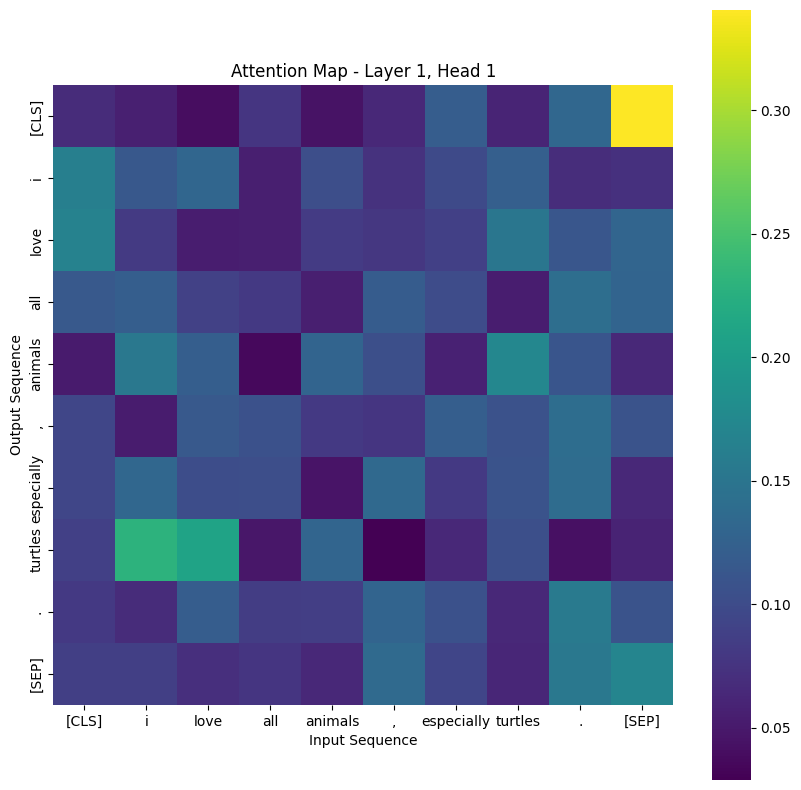

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze().tolist())

# Suppose 'attention_maps' is obtained from your BERT model
layer = 0
head = 0
# Detach the attention map of the specific head from PyTorch computation graph and convert to numpy
attention_map = attention_maps[layer][0, head].detach().cpu().numpy()

plt.figure(figsize=(10, 10))
sns.heatmap(attention_map, cmap="viridis", cbar=True, square=True,
            xticklabels=tokens, yticklabels=tokens)
plt.title(f"Attention Map - Layer {layer + 1}, Head {head + 1}")
plt.xlabel("Input Sequence")
plt.ylabel("Output Sequence")
plt.show()

In [21]:
del model

In [22]:
gc.collect()
torch.cuda.empty_cache()

# LLama Attention maps

In [5]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import transformers
import torch
from transformers.modeling_outputs import CausalLMOutput


model_name = "meta-llama/Llama-2-7b-chat-hf"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, attn_implementation="eager")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
device="cuda"
model.to(device)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm):

In [ ]:
model.config.output_attentions = True
model.config.return_dict = True
model.config.output_hidden_states = True

input_text = "Once upon a time"
input_ids = tokenizer(input_text, return_tensors='pt').input_ids.to(device)


outputs = model.generate(input_ids, max_length=50, output_attentions=True, return_dict_in_generate=True, output_hidden_states=True)

generated_ids = outputs.sequences
attention_weights = outputs.attentions
states = outputs.hidden_states

generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print(states)


In [ ]:
import llama_utils
import importlib
importlib.reload(llama_utils)
target_length = 4096
pos_embed = llama_utils.get_positional_embeddings(len(input_ids), 256, device)
transf_input = llama_utils.get_padded_input(input_ids, target_length)

embed_tokens = model.model.embed_tokens(input_ids)
embed_tokens.shape

torch.Size([1, 5, 4096])

In [ ]:
out3 = model.model.layers[0](embed_tokens, position_embeddings=pos_embed)
position_ids = torch.arange(input_ids.size(1)).unsqueeze(0)
position_ids = position_ids.to('cuda')
# out[0]

out1 = model.model.norm(out3[0])
out2 = model.model.rotary_emb(out1, position_ids)

final_output=model.lm_head(out1)
out = CausalLMOutput(logits=final_output, hidden_states=out3)
out

CausalLMOutput(loss=None, logits=tensor([[[ 1.5752,  6.7305,  0.8750,  ..., -0.4646,  2.0039, -0.7900],
         [-1.1777, -2.1895, -2.2812,  ..., -4.3828, -0.3789,  0.2798],
         [-0.6890, -1.6084, -0.9609,  ..., -0.5186,  0.7925,  0.6777],
         [ 0.8662,  2.1816, -1.9658,  ..., -0.7339,  2.7363, -0.6143],
         [-0.7163, -1.6562, -0.3721,  ..., -0.5259, -0.2170, -1.5664]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<UnsafeViewBackward0>), hidden_states=(tensor([[[ 0.0196,  0.0511, -0.0520,  ...,  0.0037,  0.0273, -0.0158],
         [ 0.0545, -0.0163, -0.0567,  ...,  0.0282, -0.0360, -0.0282],
         [ 0.0089, -0.0230, -0.0171,  ...,  0.0040,  0.0225,  0.0126],
         [ 0.0059, -0.0021, -0.0235,  ...,  0.0082,  0.0101,  0.0098],
         [ 0.0166, -0.0049, -0.0205,  ..., -0.0040,  0.0250, -0.0180]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<AddBackward0>),), attentions=None)

In [ ]:
import torch
import torch.nn.functional as F

# Apply softmax along the last dimension
softmaxed_tensor = F.softmax(final_output, dim=-1)
softmaxed_tensor

tensor([[[2.3365e-05, 4.0436e-03, 1.1563e-05,  ..., 3.0398e-06,
          3.5822e-05, 2.2054e-06],
         [5.5432e-06, 2.0266e-06, 1.8477e-06,  ..., 2.3842e-07,
          1.2398e-05, 2.3901e-05],
         [1.3471e-05, 5.3644e-06, 1.0252e-05,  ..., 1.5974e-05,
          5.9366e-05, 5.2929e-05],
         [3.5167e-05, 1.3113e-04, 2.0862e-06,  ..., 7.0930e-06,
          2.2829e-04, 7.9870e-06],
         [1.1802e-05, 4.6492e-06, 1.6689e-05,  ..., 1.4305e-05,
          1.9491e-05, 5.0664e-06]]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SoftmaxBackward0>)

In [ ]:
softmaxed_tensor.shape

torch.Size([1, 5, 32000])

In [ ]:
token_indices = softmaxed_tensor.argmax(dim=-1)

In [ ]:
token_indices

tensor([[21721,  1449, 21961, 21961,  3515]], device='cuda:0')

In [ ]:
decoded_text = tokenizer.decode(token_indices.view(-1).tolist())

In [ ]:
decoded_text

'archivi againпутапута frame'

In [ ]:
print(generated_text)

Once upon a time, in a far-off kingdom, there lived a young prince named Leo. Leo was the most handsome prince in all the land, with piercing blue eyes and golden hair that shone like the sun. He was


In [ ]:
print(attention_weights)

((tensor([[[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.9644, 0.0357, 0.0000, 0.0000, 0.0000],
          [0.9351, 0.0563, 0.0088, 0.0000, 0.0000],
          [0.4568, 0.0233, 0.0043, 0.5156, 0.0000],
          [0.1398, 0.0257, 0.0042, 0.6387, 0.1914]],

         [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.6025, 0.3977, 0.0000, 0.0000, 0.0000],
          [0.3823, 0.2939, 0.3237, 0.0000, 0.0000],
          [0.2286, 0.3184, 0.2510, 0.2020, 0.0000],
          [0.2070, 0.2343, 0.2125, 0.1666, 0.1796]],

         [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.6851, 0.3149, 0.0000, 0.0000, 0.0000],
          [0.4954, 0.2668, 0.2377, 0.0000, 0.0000],
          [0.2925, 0.3040, 0.3416, 0.0623, 0.0000],
          [0.2620, 0.2170, 0.2156, 0.1221, 0.1832]],

         [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.7070, 0.2930, 0.0000, 0.0000, 0.0000],
          [0.5327, 0.2585, 0.2086, 0.0000, 0.0000],
          [0.3726, 0.2069, 0.1841, 0.2363, 0.0000],
    

In [ ]:
outputs.attentions

KeyboardInterrupt: 

## Visualizing LLama2 attention map
### Layer 1
We can see how the attention map of the first head of the 1st layer shows that initially the focus is on the starting inputs.

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

layer_idx = 0  # The first layer
head_idx = 0   # The first attention head
batch_idx = 0

importlib.reload(visualizer)
tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
visualizer.plot_attention_map(outputs.attentions, tokens, layer_idx=0, head_idx=31)

NameError: name 'importlib' is not defined

### LLama Extraction of attention layers